In [297]:
import pandas as pd
import numpy as np
from copy import copy
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

In [299]:
from scipy.sparse import csr_matrix

In [52]:
%matplotlib inline

In [2]:
data = pd.read_csv('../created_datasets/Combine.csv')

rows = data.user_id.unique()
cols = data['isbn'].unique()
print(data.user_id.nunique(), data.isbn.nunique())
data = data[['user_id', 'isbn', 'book_rating']]

idict  = dict(zip(cols, range(len(cols))))
udict = dict(zip(rows, range(len(rows))))

data.user_id = [
    udict[i] for i in data.user_id
]
data['isbn'] = [
    idict[i] for i in data['isbn']
]

nmat = data.as_matrix()
nmat = nmat.astype(int)
print(nmat.shape)

naive = np.zeros((len(rows),len(cols)))
for row in nmat:
    naive[row[0], row[1]] = row[2]

print(naive.T.shape)

12053 4959
(470749, 3)
(4959, 12053)


# LSH with K Hash Functions and M Hash Tables

In [86]:
def get_hashes_in(data, n_hash_fn):
    rows, cols = data.shape
    #np.random.seed(42)
    hash_fns = np.random.standard_normal(size = (cols, n_hash_fn))
    bit_rep = 2 ** np.array(range(n_hash_fn -1 ,-1,-1))

    get_bits = np.dot(data, hash_fns) >= 0
    get_ints = np.dot(get_bits, bit_rep)
    
    store = {}
    
    for i in range(len(get_ints)):
        if get_ints[i] not in store:
            store[get_ints[i]] = list()
        store[get_ints[i]].append(i)

    return store, hash_fns

In [87]:
def get_hashes1(data, n_hash_fn, n_hash_t):
    rows, cols = data.shape
    hash_tables = []
    hash_funcs = []
    for i in range(n_hash_t):
        ht, hf = get_hashes_in(data, n_hash_fn)
        hash_tables.append(ht)
        hash_funcs.append(hf)
        
    return hash_tables, hash_funcs

In [308]:
def get_ksimilar1(data, idx, hf, ht, hash_tables, hash_funcs):
    n_hash_fn = hf
    bit_rep = 2 ** np.array(range(n_hash_fn -1 ,-1,-1))

    sim_items = set()
    
    for i in range(ht):
        get_bits = np.dot(data[idx,:],hash_funcs[i]) >=0
        indx = np.dot(get_bits, bit_rep)
        
        if indx in hash_tables[i]:
            sim_items.update(hash_tables[i][indx])
           
    sim_items.remove(idx)
    
    
    #Cosine similarity
    sim_ndarray = data[np.array(list(sim_items)), :]
    sims = cosine_similarity(csr_matrix(sim_ndarray), csr_matrix(data[idx,:].reshape(1,-1)))[:,0]
    
    return list(zip(list(sim_items), sims))

In [320]:
def get_ksimilar2(data, idx, hf, ht, hash_tables, hash_funcs):
    n_hash_fn = hf
    bit_rep = 2 ** np.array(range(n_hash_fn -1 ,-1,-1))

    sim_items = set()
    
    for i in range(ht):
        get_bits = np.dot(data[idx,:],hash_funcs[i]) >=0
        indx = np.dot(get_bits, bit_rep)
        
        if indx in hash_tables[i]:
            sim_items.update(hash_tables[i][indx])
           
    sim_items.remove(idx)
    
    
    #Cosine similarity
    sim_ndarray = data[np.array(list(sim_items)), :]
    sims = pairwise_distances(csr_matrix(sim_ndarray), csr_matrix(data[idx,:].reshape(1,-1)), 'euclidean')[:,0]
    sims = 1/(1+sims)
    return list(zip(list(sim_items), sims))

In [141]:
t1, t2 = get_hashes1(naive.T, 3, 3)

In [115]:
len(t1[0])

32

In [321]:
get_ksimilar2(naive.T, 1, 3, 3, t1, t2)

[(3, 0.017950640864425039),
 (15, 0.016333309349049696),
 (17, 0.017924195310633422),
 (18, 0.018936763096516762),
 (28, 0.010245119280821658),
 (31, 0.017405373730411105),
 (33, 0.017102281096912191),
 (35, 0.018039650776849193),
 (43, 0.018181818181818181),
 (44, 0.01829926810010658),
 (53, 0.017554862446034141),
 (57, 0.017158540843438642),
 (60, 0.013573956287139517),
 (66, 0.016752068049743541),
 (67, 0.017320146615915827),
 (68, 0.015130368801062177),
 (72, 0.017674473097914836),
 (73, 0.017171405216799003),
 (76, 0.018909136783460199),
 (85, 0.017756543557946168),
 (87, 0.018078637658867778),
 (93, 0.018943688737372698),
 (95, 0.018466972048042936),
 (98, 0.017413428815162908),
 (101, 0.014345240157882954),
 (102, 0.013653247735651217),
 (103, 0.015235204798843488),
 (105, 0.017367931449769544),
 (107, 0.016375555772310736),
 (109, 0.016238900224432772),
 (111, 0.019183808696768796),
 (113, 0.018403143956532472),
 (116, 0.01772527817914972),
 (124, 0.018249537029122385),
 (132, 

In [109]:
nmodel42 = []
start = time.time()
for token in range(naive.T.shape[0]):
    if(token%100 == 0):
        print(token)
    nmodel42.append(get_ksimilar1(naive.T,token, 4,2,t1,t2))
end = time.time()
tot_time42 = end - start

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [131]:
print(tot_time42/60/60, "Hrs for LSH with Two Hash Table and 4 Hash Functions")

0.33367648747232226 Hrs for LSH with Two Hash Table and 4 Hash Functions


In [116]:
nmodel52 = []
start = time.time()
for token in range(naive.T.shape[0]):
    if(token%100 == 0):
        print(token)
    nmodel52.append(get_ksimilar1(naive.T,token, 5,2,t1,t2))
end = time.time()
tot_time52 = end - start

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [130]:
print(tot_time52/60/60, "Hrs for LSH with Two Hash Table and 5 Hash Functions")

0.176792645321952 Hrs for LSH with Two Hash Table and 5 Hash Functions


In [118]:
nmodel62 = []
start = time.time()
for token in range(naive.T.shape[0]):
    if(token%100 == 0):
        print(token)
    nmodel62.append(get_ksimilar1(naive.T,token, 6,2,t1,t2))
end = time.time()
tot_time62 = end - start

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [129]:
print(tot_time62/60/60, "Hrs for LSH with Two Hash Table and 6 Hash Functions")

0.09131465971469879 Hrs for LSH with Two Hash Table and 6 Hash Functions


In [120]:
nmodel63 = []
start = time.time()
for token in range(naive.T.shape[0]):
    if(token%100 == 0):
        print(token)
    nmodel63.append(get_ksimilar1(naive.T,token, 6,3,t1,t2))
end = time.time()
tot_time63 = end - start

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [128]:
print(tot_time63/60/60, "Hrs for LSH with Three Hash Table and 6 Hash Functions")

0.14354393561681114 Hrs for LSH with Three Hash Table and 6 Hash Functions


In [123]:
nmodel53 = []
start = time.time()
for token in range(naive.T.shape[0]):
    if(token%100 == 0):
        print(token)
    nmodel53.append(get_ksimilar1(naive.T,token, 5,3,t1,t2))
end = time.time()
tot_time53 = end - start

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [127]:
print(tot_time53/60/60, "Hrs for LSH with Three Hash Table and 5 Hash Functions")

0.2720466227663888 Hrs for LSH with Three Hash Table and 5 Hash Functions


In [125]:
nmodel43 = []
start = time.time()
for token in range(naive.T.shape[0]):
    if(token%100 == 0):
        print(token)
    nmodel43.append(get_ksimilar1(naive.T,token, 4,3,t1,t2))
end = time.time()
tot_time43 = end - start

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [126]:
print(tot_time43/60/60, "Hrs for LSH with Three Hash Table and 4 Hash Functions")

0.5115059167146683 Hrs for LSH with Three Hash Table and 4 Hash Functions


In [136]:
nmodel44 = []
start = time.time()
for token in range(naive.T.shape[0]):
    if(token%100 == 0):
        print(token)
    nmodel44.append(get_ksimilar1(naive.T,token, 4,4,t1,t2))
end = time.time()
tot_time44 = end - start

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [137]:
print(tot_time44/60/60, "Hrs for LSH with Four Hash Table and 4 Hash Functions")

0.5888034505314297 Hrs for LSH with Three Hash Table and 4 Hash Functions


In [139]:
nmodel32 = []
start = time.time()
for token in range(naive.T.shape[0]):
    if(token%100 == 0):
        print(token)
    nmodel32.append(get_ksimilar1(naive.T,token, 3,2,t1,t2))
end = time.time()
tot_time32 = end - start

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [140]:
print(tot_time32/60/60, "Hrs for LSH with Two Hash Table and 3 Hash Functions")

0.6488283938831753 Hrs for LSH with Three Hash Table and 4 Hash Functions


In [142]:
nmodel33 = []
start = time.time()
for token in range(naive.T.shape[0]):
    if(token%100 == 0):
        print(token)
    nmodel33.append(get_ksimilar1(naive.T,token, 3,3,t1,t2))
end = time.time()
tot_time33 = end - start

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [143]:
print(tot_time33/60/60, "Hrs for LSH with Three Hash Table and 3 Hash Functions")

1.2936090388562944 Hrs for LSH with Three Hash Table and 3 Hash Functions


In [134]:
each_sims_n = []
each_sims_rmse_n = []
count = 1
for models in [nmodel42, nmodel43, nmodel52, nmodel53, nmodel62, nmodel63]:
    count += 1
    print(count)
    res_mod_mae_n = []
    res_mod_rmse_n = []
    for k in [5, 10, 15, 20, 25]:
        print("Number of Neighbors:", k)
        ans1, ans2 = get_results1(nmat, len(rows), len(cols), 5 , k, models, amean,umean, imean)
        res_mod_mae_n.append(ans1)
        res_mod_rmse_n.append(ans2)
    each_sims_n.append(res_mod_mae_n)
    each_sims_rmse_n.append(res_mod_rmse_n)

2
Number of Neighbors: 5
----------   Fold  1 ---------------
Test Errors
RMSE : 0.8629
MAE : 0.6116
----------   Fold  2 ---------------
Test Errors
RMSE : 0.8598
MAE : 0.6097
----------   Fold  3 ---------------
Test Errors
RMSE : 0.8571
MAE : 0.6078
----------   Fold  4 ---------------
Test Errors
RMSE : 0.8580
MAE : 0.6105
----------   Fold  5 ---------------
Test Errors
RMSE : 0.8621
MAE : 0.6115
-------------------------------------

Testing Avg Error:
AVG RMSE : 0.859971715244
AVG MAE : 0.610189085046
 
Number of Neighbors: 10
----------   Fold  1 ---------------
Test Errors
RMSE : 0.8537
MAE : 0.6079
----------   Fold  2 ---------------
Test Errors
RMSE : 0.8505
MAE : 0.6062
----------   Fold  3 ---------------
Test Errors
RMSE : 0.8480
MAE : 0.6043
----------   Fold  4 ---------------
Test Errors
RMSE : 0.8485
MAE : 0.6067
----------   Fold  5 ---------------
Test Errors
RMSE : 0.8529
MAE : 0.6081
-------------------------------------

Testing Avg Error:
AVG RMSE : 0.850733256

In [144]:
count = 1
for models in [nmodel44, nmodel32, nmodel33]:
    count += 1
    print(count)
    res_mod_mae_n = []
    res_mod_rmse_n = []
    for k in [5, 10, 15, 20, 25]:
        print("Number of Neighbors:", k)
        ans1, ans2 = get_results1(nmat, len(rows), len(cols), 5 , k, models, amean,umean, imean)
        res_mod_mae_n.append(ans1)
        res_mod_rmse_n.append(ans2)
    each_sims_n.append(res_mod_mae_n)
    each_sims_rmse_n.append(res_mod_rmse_n)

2
Number of Neighbors: 5
----------   Fold  1 ---------------
Test Errors
RMSE : 0.8314
MAE : 0.5891
----------   Fold  2 ---------------
Test Errors
RMSE : 0.8296
MAE : 0.5877
----------   Fold  3 ---------------
Test Errors
RMSE : 0.8281
MAE : 0.5863
----------   Fold  4 ---------------
Test Errors
RMSE : 0.8286
MAE : 0.5878
----------   Fold  5 ---------------
Test Errors
RMSE : 0.8287
MAE : 0.5876
-------------------------------------

Testing Avg Error:
AVG RMSE : 0.829278504885
AVG MAE : 0.587712921595
 
Number of Neighbors: 10
----------   Fold  1 ---------------
Test Errors
RMSE : 0.8168
MAE : 0.5836
----------   Fold  2 ---------------
Test Errors
RMSE : 0.8151
MAE : 0.5822
----------   Fold  3 ---------------
Test Errors
RMSE : 0.8131
MAE : 0.5806
----------   Fold  4 ---------------
Test Errors
RMSE : 0.8137
MAE : 0.5826
----------   Fold  5 ---------------
Test Errors
RMSE : 0.8142
MAE : 0.5823
-------------------------------------

Testing Avg Error:
AVG RMSE : 0.814599822

In [146]:
#nmodel42, nmodel43, nmodel52, nmodel53, nmodel62, nmodel63, nmodel44, nmodel32, nmodel33

[[0.85997171524390592,
  0.85073325621353602,
  0.84945996943467572,
  0.84926507309465893,
  0.84924211629626589],
 [0.83880358951609113,
  0.8254748189673945,
  0.82347781029325995,
  0.82303348148902811,
  0.82301267724868787],
 [0.901791316017307,
  0.89734825688748787,
  0.89697408451816418,
  0.89693570201720141,
  0.89693328882709911],
 [0.87443852412962708,
  0.86726460603407252,
  0.86636630621182087,
  0.86626247383841215,
  0.86623544606116754],
 [0.93463248972634294,
  0.9328208983914168,
  0.93272398372345311,
  0.93271431074557665,
  0.93271514673959821],
 [0.912273896230125,
  0.90883185325815785,
  0.90856514337849925,
  0.90853419706684524,
  0.90853292427633681],
 [0.82927850488535193,
  0.81459982278340259,
  0.81201279480781563,
  0.81144216577286488,
  0.8113803322435853],
 [0.82883879446874698,
  0.81390188507937444,
  0.81142713832939894,
  0.81088782698154271,
  0.81075395265058048],
 [0.81653270744361406,
  0.79944465449296476,
  0.7961130540359409,
  0.7952898

In [188]:
import matplotlib.pyplot as plt

%matplotlib inline

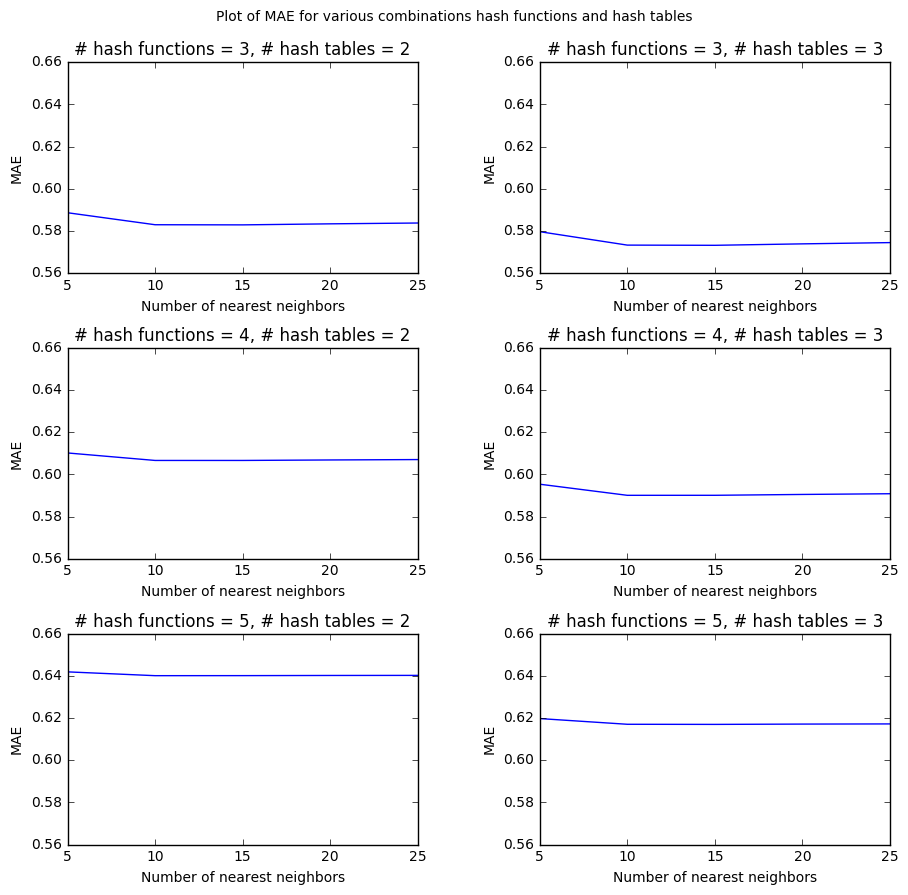

In [293]:
ll = each_sims_n[7:] + each_sims_n[:6]

hash_no = [3,4,5,6]
rep_no = [2,3]

c = 0

plt.rcParams['figure.figsize'] = (10,12)

for i in range(len(hash_no) - 1):
    for j in range(len(rep_no)):
        
        c+=1
        
        plt.subplot(4,2,c)
        plt.plot(ll[c-1])
        plt.title("# hash functions = " + str(hash_no[i]) +  ", # hash tables = " + str(rep_no[j]))
        plt.xticks(np.arange(5),[5,10,15,20,25])
        plt.ylim([0.56,0.66])
        plt.xlabel("Number of nearest neighbors")
        plt.ylabel("MAE")
        
        
plt.suptitle("Plot of MAE for various combinations hash functions and hash tables")
plt.tight_layout(h_pad=1, pad=4)
plt.savefig('LSH_MAE')

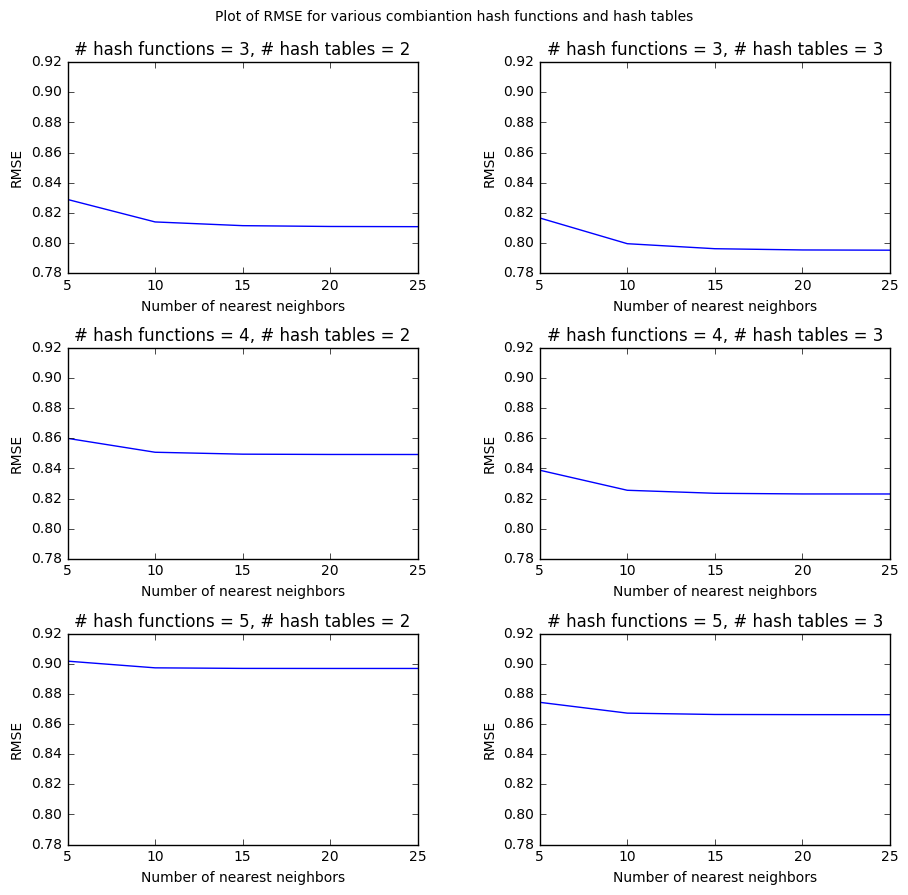

In [295]:
ll = each_sims_rmse_n[7:] + each_sims_rmse_n[:6]

hash_no = [3,4,5,6]
rep_no = [2,3]

c = 0

#plt.rcParams['figure.figsize'] = (8,10)

for i in range(len(hash_no) -1):
    for j in range(len(rep_no)):
        
        c+=1
        
        plt.subplot(4,2,c)
        plt.plot(ll[c-1])
        plt.title("# hash functions = " + str(hash_no[i]) +  ", # hash tables = " + str(rep_no[j]))
        plt.xticks(np.arange(5),[5,10,15,20,25])
        plt.ylim([0.78,0.92])
        plt.xlabel("Number of nearest neighbors")
        plt.ylabel("RMSE")
        
        
plt.suptitle("Plot of RMSE for various combiantion hash functions and hash tables")
plt.tight_layout(h_pad=1, pad=4)
plt.savefig('LSH_RMSE')

In [270]:
timings = [14780.524564027786,tot_time32, tot_time33, tot_time42, tot_time43, tot_time52, tot_time53, tot_time62, tot_time63]

In [277]:
timings = timings[:7]

In [247]:
hash_no = [3,4,5,6]
rep_no = [2,3]

plt.rcParams['figure.figsize'] = (17,5)

c = 0

# for i in range(len(hash_no)):
#     for j in range(len(rep_no)):
        
#         c += 1
#         plt.subplot(1,len(timings),c)
#         plt.bar(c,height = timings[c-1])
        
#         plt.xticks([])
#         plt.xlabel()
        
#         if(c != 1):
#             plt.yticks([])
        
        

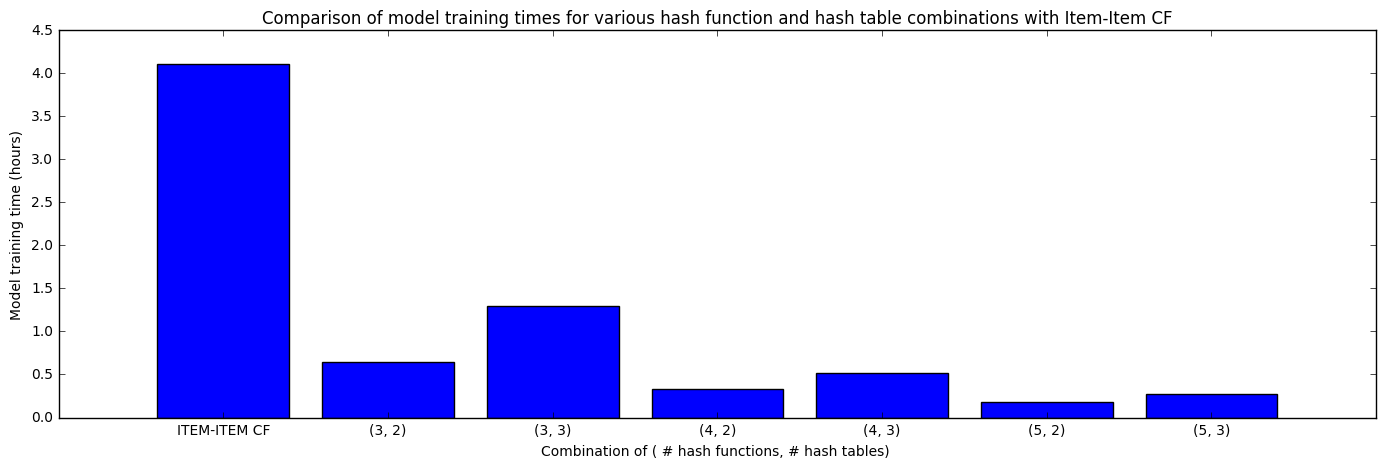

In [322]:
plt.rcParams['figure.figsize'] = (17,5)
plt.bar(np.arange(len(timings)),np.array(timings)/60/60, align='center');
plt.xticks(np.arange(7),['ITEM-ITEM CF', (3,2),(3,3),(4,2),(4,3),(5,2),(5,3)])
plt.xlabel("Combination of ( # hash functions, # hash tables) ");
plt.ylabel("Model training time (hours)");
plt.title("Comparison of model training times for various hash function and hash table combinations with Item-Item CF")
plt.savefig('TimingComp')
#plt.axhline(np.mean(timings), c = 'green', linestyle='--');

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


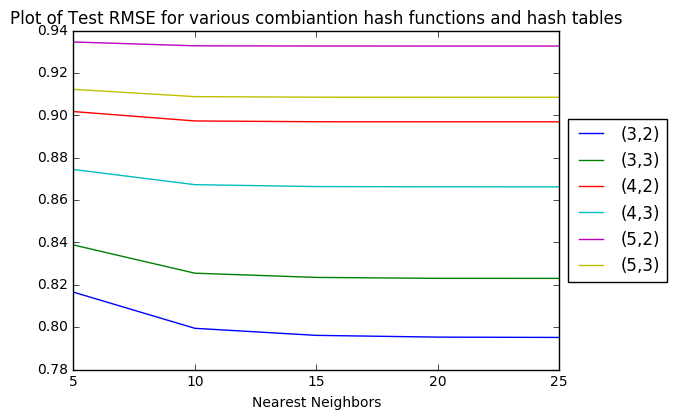

In [404]:
plt.rcParams['figure.figsize'] = (8,5)
results_df_lsh = pd.DataFrame({'Nearest Neighbors': [5, 10, 15, 20, 25], '(3,2)': each_sims_rmse_n[-1], '(3,3)': each_sims_rmse_n[1], '(4,2)': each_sims_rmse_n[2], '(4,3)': each_sims_rmse_n[3], '(5,2)':each_sims_rmse_n[4], '(5,3)':each_sims_rmse_n[5]})
plot2 = results_df_lsh.plot(x='Nearest Neighbors', y=['(3,2)', '(3,3)', '(4,2)', '(4,3)','(5,2)', '(5,3)'], ylim=(0.78,0.94), title = 'Plot of Test RMSE for various combiantion hash functions and hash tables')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig = plot2.get_figure()
fig.savefig('LSH_RMSE.png')
plt.tight_layout(h_pad=3,pad=3)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


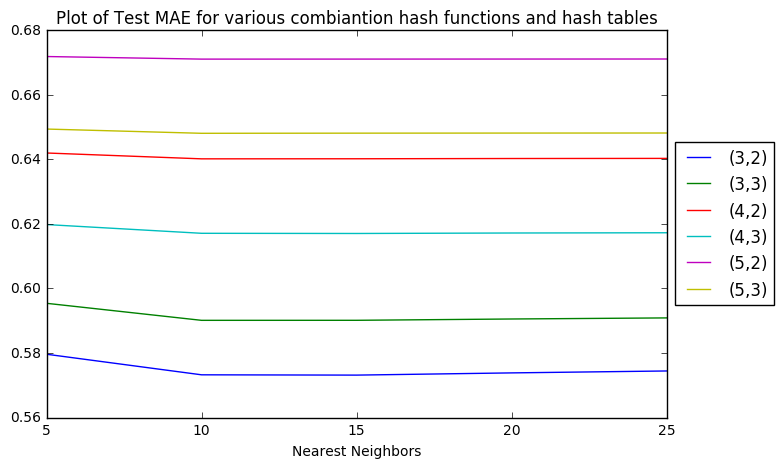

In [402]:
plt.rcParams['figure.figsize'] = (8,5)
results_df_mae = pd.DataFrame({'Nearest Neighbors': [5, 10, 15, 20, 25], '(3,2)': each_sims_n[-1], '(3,3)': each_sims_n[1], '(4,2)': each_sims_n[2], '(4,3)': each_sims_n[3], '(5,2)':each_sims_n[4], '(5,3)':each_sims_n[5]})
plot2 = results_df_mae.plot(x='Nearest Neighbors', y=['(3,2)', '(3,3)', '(4,2)', '(4,3)','(5,2)', '(5,3)'], ylim=(0.56,0.68), title = 'Plot of Test MAE for various combiantion hash functions and hash tables')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig = plot2.get_figure()
fig.savefig('LSH_MAE.png')

In [260]:
cov1lsh = []
cov2lsh = []
cov3lsh = []
cov4lsh = []
cov5lsh = []
mlist = [5,10,15,20,25]
for i in range(len(rows)):
    if(i%100 == 0):
        print(i)
    ans = coverage(full_mat, i, nmodel33, 15, mlist, flipped_dict, True)
    cov1lsh.extend(ans[0])
    cov2lsh.extend(ans[1])
    cov3lsh.extend(ans[2])
    cov4lsh.extend(ans[3])
    cov5lsh.extend(ans[4])

0


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000


In [262]:
print("Coverage with recommending 5 books", len(set(cov1lsh))/4959 *100 ,"%")

Coverage with recommending 5 books 34.704577535793504 %


In [263]:
print("Coverage with recommending 10 books", len(set(cov2lsh))/4959 *100 ,"%")

Coverage with recommending 10 books 52.57108287961283 %


In [264]:
print("Coverage with recommending 15 books", len(set(cov3lsh))/4959 *100 ,"%")

Coverage with recommending 15 books 65.63823351482154 %


In [265]:
print("Coverage with recommending 20 books", len(set(cov4lsh))/4959 *100 ,"%")

Coverage with recommending 20 books 73.80520266182698 %


In [266]:
print("Coverage with recommending 25 books", len(set(cov5lsh))/4959 *100 ,"%")

Coverage with recommending 25 books 79.57249445452712 %


### Testing the model less popular Books

In [345]:
idnums = []
for i in cov5lsh:
    idnums.append(idict[i])
    

In [348]:
len(set(idnums))/4959

0.7957249445452712

In [352]:
idnums1 = set(idnums)

In [353]:
len(idnums1)

3946

In [358]:
smalldata = data[~data.isbn.isin(list(idnums))]

In [368]:
r1 = smalldata.user_id.nunique()
c1 = smalldata.isbn.nunique()

In [376]:
r1 = smalldata.user_id.unique()
c1 = smalldata['isbn'].unique()

idict1  = dict(zip(c1, range(len(c1))))
udict1 = dict(zip(r1, range(len(r1))))

smalldata.user_id = [
    udict1[i] for i in smalldata.user_id
]
smalldata['isbn'] = [
    idict1[i] for i in smalldata['isbn']
]

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [377]:
nmat1 = smalldata.as_matrix()

In [378]:
nmat1 = nmat1.astype(int)

In [380]:
naivesmall = np.zeros((len(r1),len(c1)))
for row in nmat1:
    naivesmall[row[0], row[1]] = row[2]

In [381]:
naivesmall.shape

(11092, 1013)

In [406]:
ts1, ts2 = get_hashes1(naivesmall.T, 3, 3)

In [407]:
nsmallmodel33 = []
start = time.time()
for token in range(naivesmall.T.shape[0]):
    if(token%100 == 0):
        print(token)
    nsmallmodel33.append(get_ksimilar1(naivesmall.T,token, 3,3,ts1,ts2))
end = time.time()
tot_time33 = end - start

0
100
200
300
400
500
600
700
800
900
1000


In [408]:
get_results1(nmat1, len(r1), len(c1), 5 ,15, nmodel33, amean,umean, imean)

----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


Test Errors
RMSE : 1.3134
MAE : 1.0171
----------   Fold  2 ---------------
Test Errors
RMSE : 1.3200
MAE : 1.0210
----------   Fold  3 ---------------
Test Errors
RMSE : 1.3167
MAE : 1.0150
----------   Fold  4 ---------------
Test Errors
RMSE : 1.3170
MAE : 1.0175
----------   Fold  5 ---------------
Test Errors
RMSE : 1.3154
MAE : 1.0183
-------------------------------------

Testing Avg Error:
AVG RMSE : 1.31650288406
AVG MAE : 1.01777694059
 


(1.0177769405909096, 1.3165028840572273)